Using device: cuda
Dataset Path: /kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer
Total dataset size: 25000
Training set size: 17500
Validation set size: 3750
Test set size: 3750
Found 5 classes: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Epoch 1/20 | Train Loss: 0.4066 | Train Acc: 0.8693 | Val Loss: 0.0876 | Val Acc: 0.9763
Epoch 2/20 | Train Loss: 0.1422 | Train Acc: 0.9631 | Val Loss: 0.0698 | Val Acc: 0.9803
Epoch 3/20 | Train Loss: 0.1151 | Train Acc: 0.9739 | Val Loss: 0.0756 | Val Acc: 0.9864
Epoch 4/20 | Train Loss: 0.0877 | Train Acc: 0.9815 | Val Loss: 0.0311 | Val Acc: 0.9933
Epoch 5/20 | Train Loss: 0.0701 | Train Acc: 0.9862 | Val Loss: 0.0461 | Val Acc: 0.9936
Epoch 6/20 | Train Loss: 0.0734 | Train Acc: 0.9866 | Val Loss: 0.0177 | Val Acc: 0.9955
Epoch 7/20 | Train Loss: 0.0799 | Train Acc: 0.9886 | Val Loss: 0.0114 | Val Acc: 0.9976
Epoch 8/20 | Train Loss: 0.0730 | Train Acc: 0.9889 | Val Loss: 0.0202 | Val Acc: 0.9987
E

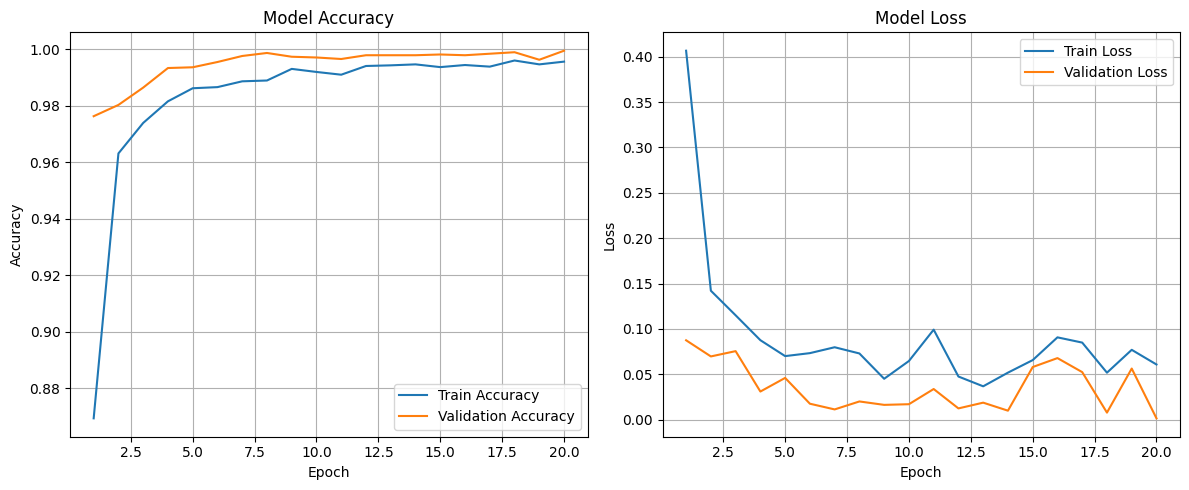


--- Evaluation Metrics ---

Classification Report:
              precision    recall  f1-score   support

  cervix_dyk       1.00      1.00      1.00       779
  cervix_koc       1.00      1.00      1.00       756
  cervix_mep       1.00      1.00      1.00       719
  cervix_pab       1.00      1.00      1.00       759
  cervix_sfi       1.00      1.00      1.00       737

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

Per-Class Accuracy:
  cervix_dyk: 1.0000
  cervix_koc: 1.0000
  cervix_mep: 0.9958
  cervix_pab: 1.0000
  cervix_sfi: 1.0000


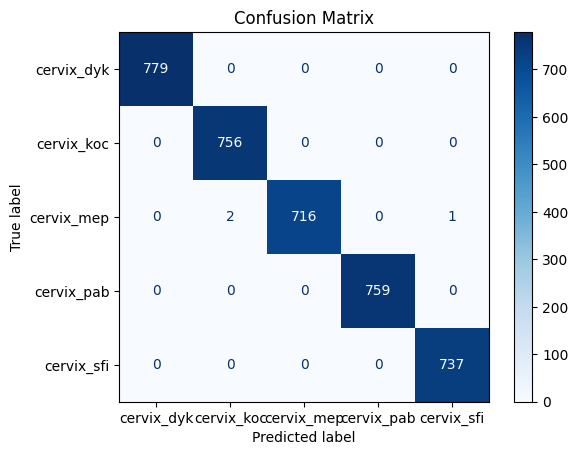


--- ROC and AUC ---
AUC for class cervix_dyk: 1.0000
AUC for class cervix_koc: 1.0000
AUC for class cervix_mep: 1.0000
AUC for class cervix_pab: 1.0000
AUC for class cervix_sfi: 1.0000

Micro-average AUC: 1.0000


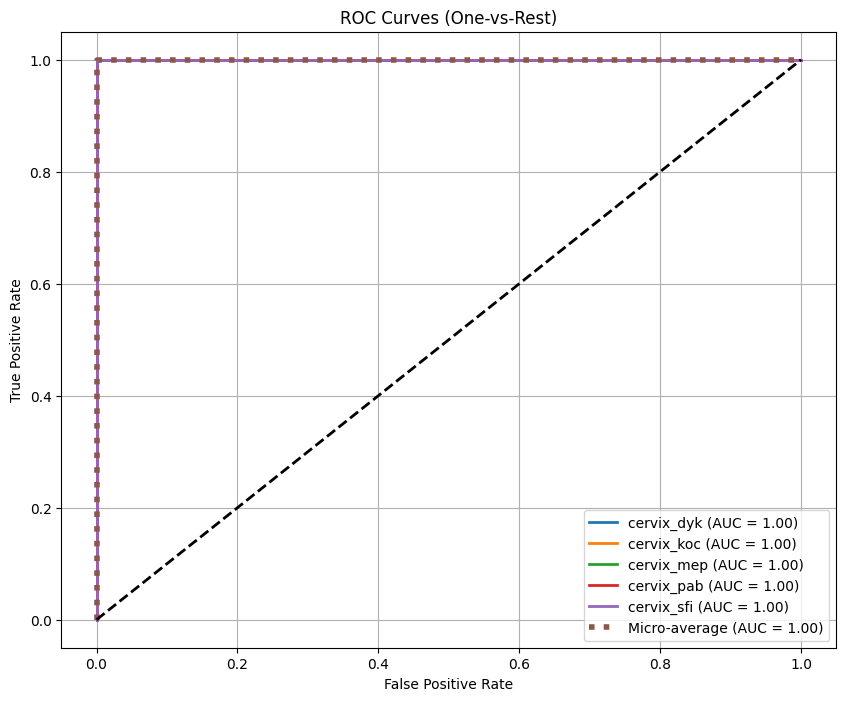

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import time
import torch.nn.functional as F
from copy import deepcopy

# --- 1. Configuration and Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ REQUIREMENTS: Set all parameters as requested
DATA_PATH = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer"
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20 # Set to 20 epochs

# --- 2. Data Loading, Augmentation, and Splitting ---
# Data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simpler transform for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset and apply transforms correctly
full_dataset = datasets.ImageFolder(root=DATA_PATH)
class_names = full_dataset.classes
NUM_CLASSES = len(class_names)

# Split into train, val, test subsets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Wrapper to apply transforms to subsets
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, transform=train_transform)
val_dataset = TransformedDataset(val_subset, transform=val_test_transform)
test_dataset = TransformedDataset(test_subset, transform=val_test_transform)


# ✅ REQUIREMENT: Report dataset sizes
print(f"Dataset Path: {DATA_PATH}")
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Found {NUM_CLASSES} classes: {class_names}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# --- 3. Model Definition (Transfer Learning with VGG16) ---
model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze all convolutional layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional block for fine-tuning
for param in model.features[24:].parameters():
    param.requires_grad = True
    
# Replace the classifier
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, NUM_CLASSES)

model = model.to(device)

# --- 4. Training Function (NO Early Stopping) ---
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    start_time = time.time()
    best_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save model if validation accuracy has improved
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            
    training_time = time.time() - start_time
    print(f"\nBest Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history, training_time

# --- 5. Evaluation Function ---
def evaluate_model(model, test_loader):
    start_time = time.time()
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    
    testing_time = time.time() - start_time
    return np.array(y_true), np.array(y_pred), np.array(y_probs), testing_time

# --- 6. Main Execution and Reporting ---
criterion = nn.CrossEntropyLoss()

# Optimizer for fine-tuning: different learning rates for different parts of the network
optimizer = optim.Adam([
    {'params': model.features[24:].parameters(), 'lr': 1e-5}, # Lower LR for conv layers
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE} # Higher LR for new classifier
])

model, history, training_time = train_model(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS)

y_true, y_pred, y_probs, testing_time = evaluate_model(model, test_loader)

# --- 7. Output All Required Metrics ---

# ✅ REQUIREMENT: Report training and testing time
print("\n--- Performance Timing ---")
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Testing Time: {testing_time:.2f} seconds")

# ✅ REQUIREMENT: Plot Learning Curves
print("\n--- Learning Curves ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ REQUIREMENT: Classification Report, Confusion Matrix, and Per-Class Accuracy
print("\n--- Evaluation Metrics ---")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Per-Class Accuracy:")
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"  {class_names[i]}: {acc:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ✅ REQUIREMENT: Plot ROC Curve and report AUC
print("\n--- ROC and AUC ---")
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class {class_names[i]}: {roc_auc[i]:.4f}")
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
plt.plot(fpr["micro"], tpr["micro"], ':', lw=4, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()